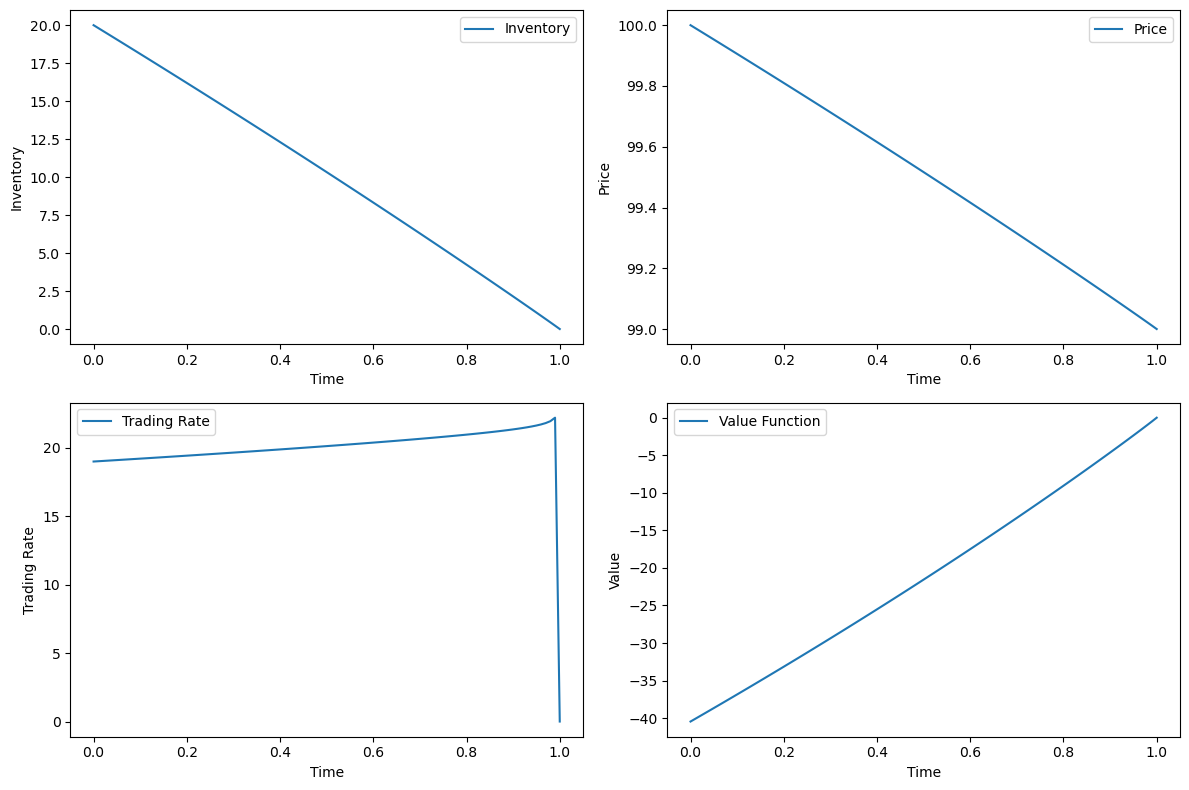

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Parameters
lambda_true = 0.1  # Temporary impact
gamma_true = 0.05  # Permanent impact
alpha = 1.0  # Terminal penalty
T = 1.0  # Time horizon
Q_0 = 20.0  # Initial inventory
S_0 = 100.0  # Initial price
dt = 0.01  # Time step
n_steps = int(T / dt)
n_trajectories = 1000

# Simulate optimal trading trajectory (approximate q_t^*)
def optimal_trading_rate(t, x, S, lambda_t, gamma_t):
    # Simplified approximation: TWAP-like with adjustment for impacts
    # In practice, solve the HJB PDE numerically for q_t^*
    remaining_time = T - t
    if remaining_time > 0:
        q_t = x / remaining_time  # Basic TWAP
        # Adjust based on impacts (heuristic)
        q_t *= (1 - 0.5 * lambda_t * x / Q_0)
    else:
        q_t = 0
    return max(q_t, 0)

# Generate one trajectory
def simulate_trajectory():
    t = np.linspace(0, T, n_steps)
    x = np.zeros(n_steps)
    S = np.zeros(n_steps)
    q = np.zeros(n_steps)
    costs = np.zeros(n_steps)
    
    x[0] = Q_0
    S[0] = S_0
    
    for i in range(n_steps - 1):
        t_i = t[i]
        q[i] = optimal_trading_rate(t_i, x[i], S[i], lambda_true, gamma_true)
        S[i + 1] = S[i] - gamma_true * q[i] * dt
        x[i + 1] = x[i] - q[i] * dt
        costs[i] = -lambda_true * q[i]**2 * dt
    
    # Terminal cost
    costs[-1] = -alpha * x[-1]**2
    
    # Approximate value function: cumulative cost from t to T
    V = np.cumsum(costs[::-1])[::-1]
    
    return t, x, S, q, V

# Generate multiple trajectories
trajectories = []
for _ in range(n_trajectories):
    t, x, S, q, V = simulate_trajectory()
    trajectories.append((t, x, S, q, V))

# Save data
data = {
    't': np.array([traj[0] for traj in trajectories]),
    'x': np.array([traj[1] for traj in trajectories]),
    'S': np.array([traj[2] for traj in trajectories]),
    'q': np.array([traj[3] for traj in trajectories]),
    'V': np.array([traj[4] for traj in trajectories])
}
np.savez('almgren_chriss_data.npz', **data)

# Plot one trajectory
t, x, S, q, V = trajectories[0]
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(t, x, label='Inventory')
plt.xlabel('Time')
plt.ylabel('Inventory')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(t, S, label='Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(t, q, label='Trading Rate')
plt.xlabel('Time')
plt.ylabel('Trading Rate')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(t, V, label='Value Function')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Parameters
lambda_t_fixed = 0.1
gamma_t_fixed = 0.05
alpha_terminal_penalty = 100.0  # <<<< Increased terminal penalty further
T_horizon = 1.0
Q_0 = 20.0
S_0 = 100.0
dt = 0.01
n_steps = int(T_horizon / dt)

n_episodes = 300
n_test_episodes = 10

action_bound_rate = 40.0
state_dim = 3
action_dim = 1
hidden_dim = 128

lr_actor = 1e-4
lr_critic = 1e-3
gamma_discount = 0.99
tau_target_update = 0.005
buffer_size = 10000
batch_size = 64
initial_exploration_noise_std = 0.15 * action_bound_rate # <<<< Reduced initial noise fraction
min_exploration_noise_std = 0.01 * action_bound_rate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [26]:

# --- Actor Network ---
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, max_action_rate):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Sigmoid()
        )
        self.max_action_rate = max_action_rate

    def forward(self, state):
        action_normalized = self.net(state)
        return self.max_action_rate * action_normalized



In [27]:


# --- Critic Network (Standard DDPG Structure) ---
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.net(x)



In [28]:


# --- DDPG Agent ---
class DDPG:
    def __init__(self):
        self.actor = Actor(state_dim, action_dim, hidden_dim, action_bound_rate).to(device)
        self.actor_target = Actor(state_dim, action_dim, hidden_dim, action_bound_rate).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        self.critic = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic, weight_decay=1e-2)

        self.replay_buffer = deque(maxlen=buffer_size)
        self.criterion = nn.MSELoss()
        self.learning_starts_step = batch_size * 5

    def select_action(self, state, current_inventory, current_dt, noise_std=0.0):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad(): # Ensure actor is in eval mode for action selection if not training
             action_rate = self.actor(state_tensor).cpu().numpy()[0] # Removed detach as no_grad handles it

        if noise_std > 0:
            noise = np.random.normal(0, noise_std, size=action_dim)
            action_rate += noise

        action_rate = np.clip(action_rate, 0, self.actor.max_action_rate)
        
        # Ensure action does not oversell based on inventory and dt
        # This is the rate q_t. Amount sold is q_t * dt.
        # So, max feasible rate is current_inventory / current_dt
        max_feasible_rate_this_step = current_inventory / current_dt if current_dt > 0 else current_inventory
        action_rate[0] = min(action_rate[0], max_feasible_rate_this_step)
        action_rate[0] = max(0, action_rate[0]) # Ensure rate is not negative after noise and clipping

        return action_rate

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def update(self):
        if len(self.replay_buffer) < self.learning_starts_step:
            return 0.0, 0.0

        batch = random.sample(self.replay_buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        state = torch.FloatTensor(np.array(state)).to(device)
        action_from_buffer = torch.FloatTensor(np.array(action)).to(device) # Renamed to avoid confusion
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(np.array(next_state)).to(device)
        done = torch.FloatTensor(done).unsqueeze(1).to(device)

        # Critic update
        with torch.no_grad():
            target_actions = self.actor_target(next_state)
            target_q_values = self.critic_target(next_state, target_actions)
            target_q = reward + (1 - done) * gamma_discount * target_q_values

        current_q = self.critic(state, action_from_buffer) # Use action from buffer
        critic_loss = self.criterion(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0) # <<<< Gradient Clipping
        self.critic_optimizer.step()

        # Actor update
        actor_policy_actions = self.actor(state) # Actions from current actor policy
        actor_loss = -self.critic(state, actor_policy_actions).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0) # <<<< Gradient Clipping
        self.actor_optimizer.step()

        # Update target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau_target_update * param.data + (1 - tau_target_update) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau_target_update * param.data + (1 - tau_target_update) * target_param.data)
        
        return critic_loss.item(), actor_loss.item()



In [29]:


# --- Environment ---
class AlmgrenChrissEnv:
    def __init__(self):
        self.lambda_param = lambda_t_fixed
        self.gamma_param = gamma_t_fixed
        self.alpha_penalty = alpha_terminal_penalty
        self.T_horizon = T_horizon
        self.Q_0 = Q_0
        self.S_0 = S_0
        self.dt = dt
        self.n_steps = n_steps
        self.current_step = 0
        self.reset()

    def reset(self):
        self.t = 0.0
        self.x = self.Q_0
        self.S = self.S_0
        self.current_step = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        norm_t = self.t / self.T_horizon
        norm_x = self.x / self.Q_0
        S_min_norm, S_max_norm = S_0 - 15, S_0 + 5 # Wider range if price tends to drop
        norm_S = np.clip((self.S - S_min_norm) / (S_max_norm - S_min_norm), -0.5, 1.5) # Allow slight out of bound for NN
        return np.array([norm_t, norm_x, norm_S])

    def step(self, action_rate_array):
        if self.done:
            return self._get_state(), 0, True, {}

        q_t_rate = action_rate_array[0] # This is the target trading rate from actor

        # Actual shares to sell in this step is rate * dt, clipped by current inventory
        shares_to_sell_this_step = min(q_t_rate * self.dt, self.x)
        # Recalculate the actual rate achieved
        actual_executed_q_t_rate = shares_to_sell_this_step / self.dt if self.dt > 0 else 0.0


        # REWARD DESIGN:
        trading_cost = self.lambda_param * (actual_executed_q_t_rate**2) * self.dt
        # Significantly stronger running inventory penalty
        inventory_penalty_per_step = 5.0 * (self.x / self.Q_0)**2 * self.dt # <<<< Increased weight
        # Small positive reward for selling
        selling_reward = 0.1 * (shares_to_sell_this_step / (self.Q_0 * self.dt + 1e-9) ) # Proportional to normalized sell amount


        reward = -trading_cost - inventory_penalty_per_step + selling_reward

        self.S -= self.gamma_param * actual_executed_q_t_rate * self.dt
        self.x -= shares_to_sell_this_step
        self.x = max(self.x, 0)

        self.t += self.dt
        self.current_step += 1

        terminal_reward_boost = 0

        if self.current_step >= self.n_steps or self.x < 1e-6: # Check if liquidation is complete or time is up
            self.done = True
            terminal_inventory_penalty = self.alpha_penalty * (self.x / self.Q_0)**2
            reward -= terminal_inventory_penalty
            if self.x < 1e-6: # Successfully liquidated
                terminal_reward_boost = 50.0 # <<<< Large bonus for full liquidation
                reward += terminal_reward_boost
        return self._get_state(), reward, self.done, {}



In [30]:


# --- TWAP Strategy (Theoretical Optimal for this setup) ---
class TWAP:
    def __init__(self, Q_0, T_horizon, dt_env):
        self.rate_per_step = Q_0 / T_horizon if T_horizon > 0 else 0.0
        self.dt = dt_env

    def __call__(self, state_tuple, current_inventory):
        # Return the constant rate
        # Ensure the returned action is an array for consistency with DDPG action
        return np.array([self.rate_per_step])



In [31]:


# --- Training and Evaluation ---
def run_experiment():
    env = AlmgrenChrissEnv()
    agent = DDPG()
    twap_strategy = TWAP(Q_0, T_horizon, dt)
    # Removed theo_opt_strategy as TWAP is the benchmark here

    print("Filling replay buffer...")
    state = env.reset()
    for _ in range(agent.learning_starts_step):
        action_rate = agent.select_action(state, env.x, env.dt, noise_std=initial_exploration_noise_std)
        next_state, reward, done, _ = env.step(action_rate)
        agent.store_transition(state, action_rate, reward, next_state, done)
        state = next_state
        if done:
            state = env.reset()
    print(f"Buffer filled with {len(agent.replay_buffer)} samples.")

    print("Training DDPG agent...")
    episode_rewards = []
    avg_final_inventories = []
    actor_losses_log = []
    critic_losses_log = []

    for episode in range(n_episodes):
        state = env.reset()
        current_episode_reward = 0
        # Anneal noise: make it smaller and decay slower
        current_noise_std = initial_exploration_noise_std * (1 / (1 + episode * 0.05))
        current_noise_std = max(current_noise_std, min_exploration_noise_std)


        for step_num in range(n_steps):
            action_rate = agent.select_action(state, env.x, env.dt, noise_std=current_noise_std)
            next_state, reward, done, _ = env.step(action_rate)
            agent.store_transition(state, action_rate, reward, next_state, done)
            
            c_loss, a_loss = agent.update()
            if c_loss != 0:
                critic_losses_log.append(c_loss)
                actor_losses_log.append(a_loss)
            
            state = next_state
            current_episode_reward += reward
            if done:
                break
        
        episode_rewards.append(current_episode_reward)
        avg_final_inventories.append(env.x)

        if episode % (n_episodes // 20 if n_episodes >=20 else 1) == 0 or episode == n_episodes - 1:
            print(f"Ep {episode}, Reward: {current_episode_reward:.2f}, Final Inv: {env.x:.2f}, Noise: {current_noise_std:.3f}")
            if len(critic_losses_log) > 100:
                 print(f"  Avg Critic Loss (last 100): {np.mean(critic_losses_log[-100:]):.4f}, Avg Actor Loss (last 100): {np.mean(actor_losses_log[-100:]):.4f}")

    # Plotting training diagnostics
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0,0].plot(episode_rewards)
    axs[0,0].set_title("Episode Rewards")
    axs[0,0].grid(True)
    axs[0,1].plot(avg_final_inventories)
    axs[0,1].set_title("Final Inventory per Episode")
    axs[0,1].grid(True)
    if critic_losses_log:
        axs[1,0].plot(critic_losses_log)
        axs[1,0].set_title("Critic Losses (per update step)")
        axs[1,0].set_yscale('log') # Use log scale for losses if they vary a lot
        axs[1,0].grid(True)
        axs[1,1].plot(actor_losses_log)
        axs[1,1].set_title("Actor Losses (per update step)")
        axs[1,1].grid(True)
    plt.tight_layout()
    plt.show()

    # Testing
    print("Testing DDPG agent...")
    ddpg_inventories = []
    twap_inventories = []

    for _ in range(n_test_episodes):
        # DDPG
        state = env.reset()
        inventory_run = [env.x]
        for _ in range(n_steps):
            action_rate = agent.select_action(state, env.x, env.dt, noise_std=0)
            state, _, done, _ = env.step(action_rate)
            inventory_run.append(env.x)
            if done: break
        ddpg_inventories.append(inventory_run + [inventory_run[-1]] * (n_steps + 1 - len(inventory_run)))

        # TWAP
        state = env.reset()
        inventory_run = [env.x]
        for _ in range(n_steps):
            action_rate = twap_strategy(state, env.x)
            # Env step handles clipping action to inventory
            state, _, done, _ = env.step(action_rate)
            inventory_run.append(env.x)
            if done: break
        twap_inventories.append(inventory_run + [inventory_run[-1]] * (n_steps + 1 - len(inventory_run)))

    ddpg_avg = np.mean(ddpg_inventories, axis=0)
    twap_avg = np.mean(twap_inventories, axis=0)

    time_axis = np.linspace(0, T_horizon, n_steps + 1)
    plt.figure(figsize=(10, 6)) # Reduced size slightly for single plot
    plt.plot(time_axis, ddpg_avg, label='DDPG Avg. Inventory', color='green', linestyle='--')
    plt.plot(time_axis, twap_avg, label='TWAP Avg. Inventory', color='red', linestyle='-.')
    plt.xlabel('Time')
    plt.ylabel('Average Inventory')
    plt.title('Average Inventory Trajectories (Test Episodes)')
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=-0.5, top=Q_0 + 1)
    plt.show()



Filling replay buffer...
Buffer filled with 320 samples.
Training DDPG agent...
Ep 0, Reward: -29.28, Final Inv: 2.14, Noise: 6.000
Ep 15, Reward: -92.66, Final Inv: 18.77, Noise: 3.429
  Avg Critic Loss (last 100): 44.7596, Avg Actor Loss (last 100): 1.1388
Ep 30, Reward: -94.38, Final Inv: 18.95, Noise: 2.400
  Avg Critic Loss (last 100): 62.7408, Avg Actor Loss (last 100): 3.1131
Ep 45, Reward: -97.18, Final Inv: 19.24, Noise: 1.846
  Avg Critic Loss (last 100): 61.1220, Avg Actor Loss (last 100): 5.2582
Ep 60, Reward: -65.01, Final Inv: 15.47, Noise: 1.500
  Avg Critic Loss (last 100): 54.2341, Avg Actor Loss (last 100): 6.6603
Ep 75, Reward: -49.19, Final Inv: 13.04, Noise: 1.263
  Avg Critic Loss (last 100): 26.6878, Avg Actor Loss (last 100): 8.1050
Ep 90, Reward: -80.40, Final Inv: 17.42, Noise: 1.091
  Avg Critic Loss (last 100): 32.7348, Avg Actor Loss (last 100): 10.5458
Ep 105, Reward: -89.52, Final Inv: 18.45, Noise: 0.960
  Avg Critic Loss (last 100): 19.4470, Avg Actor L

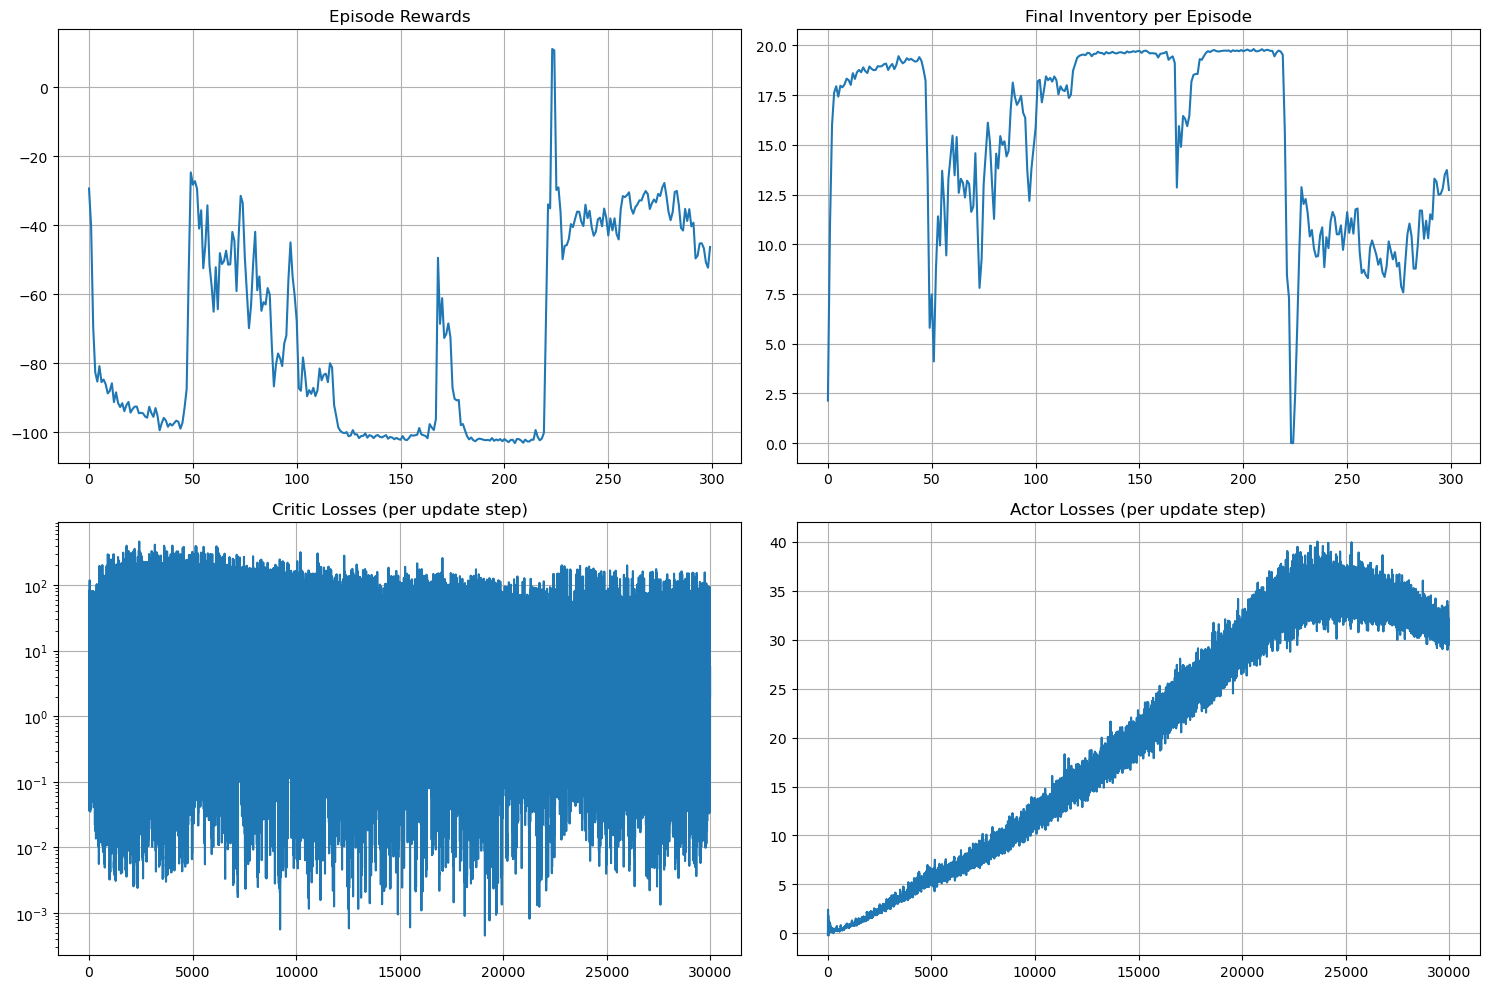

Testing DDPG agent...


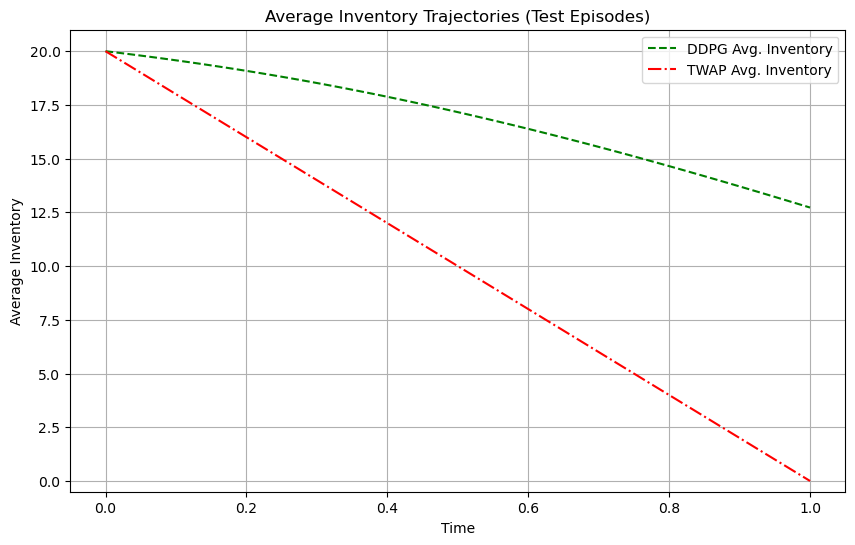

In [ ]:

if __name__ == "__main__":
    run_experiment()